In [68]:
import jax
import jax.numpy as jnp
import jax.random as jr
import optax

# import matplotlib
# matplotlib.use('TkAgg') # need this on my machine for some reason
import matplotlib.pyplot as plt
import wandb
import pickle
import os

# %pip uninstall nmrnn
# %pip install git+https://github.com/lindermanlab/nm-rnn.git@main
from nmrnn.data_generation import sample_all
from nmrnn.util import random_nmrnn_params, log_wandb_model, load_wandb_model
from nmrnn.fitting import fit_mwg_nm_rnn, fit_mwg_nm_only
from nmrnn.rnn_code import batched_nm_rnn
!wandb login

wandb: Currently logged in as: jcostacurta11. Use `wandb login --relogin` to force relogin


In [69]:
wandb.init(entity='nm-rnn', project='nm-rnn-mwg', id='y75s2gnj', resume='allow')

model = load_wandb_model('nm-rnn/nm-rnn-mwg/nmrnn_r3_n100_m5:v10')


wandb: WARNING No requirements.txt found, not creating job artifact. See https://docs.wandb.ai/guides/launch/create-job


wandb:   1 of 1 files downloaded.  


/var/folders/8g/txhrz9cj65966xcf7jyfx5200000gn/T/ipykernel_29272/4228860120.py:24: MatplotlibDeprecationWarning: The toggle_label function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use ax.tick_params and colorbar.set_label instead.
  ax.cax.toggle_label(True)


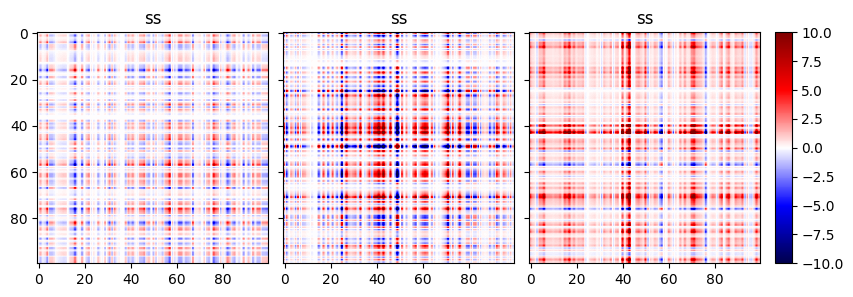

In [66]:
from mpl_toolkits.axes_grid1 import ImageGrid

# Set up figure and image grid
fig = plt.figure(figsize=(9.75, 3))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,3),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

# Add data to image grid
for r, ax in enumerate(grid):
    rank_component = (model['column_factors'][:,r][:,None] @ model['column_factors'][:,r][None,:])
    # divide by norm of all 3 components
    im = ax.imshow(rank_component,cmap='seismic', vmax=10, vmin=-10)
    #ax.set_title('ss')

# Colorbar
ax.cax.colorbar(im)
ax.cax.toggle_label(True)

#plt.tight_layout()    # Works, but may still require rect paramater to keep colorbar labels visible
plt.show()

In [75]:
# generate data for all intervals (4 trained, plus 4 shorter/longer)
new_intervals = jnp.array([[4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]])
# middling cue time (but could change this)
measure_min = 15
measure_max = 16

new_inputs, new_outputs, new_masks = sample_all(110,
           new_intervals,
            measure_min,
            measure_max,
            15,)

x0 = jnp.ones((100,))*0.1
z0 = jnp.ones((5,))*0.1

ys, xs, zs = batched_nm_rnn(model, x0, z0, new_inputs, 10, 100)

In [77]:
xs.shape

(12, 110, 100)

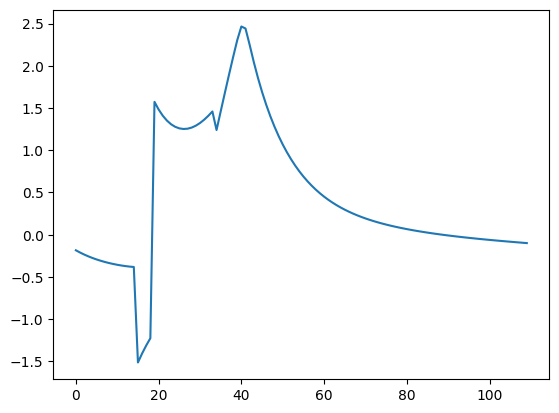

In [86]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 10)
pca.fit(jnp.vstack(xs))

xs_pca = pca.transform(jnp.vstack(xs)).reshape((12,110,10))
plt.plot(xs_pca[0,:,3])

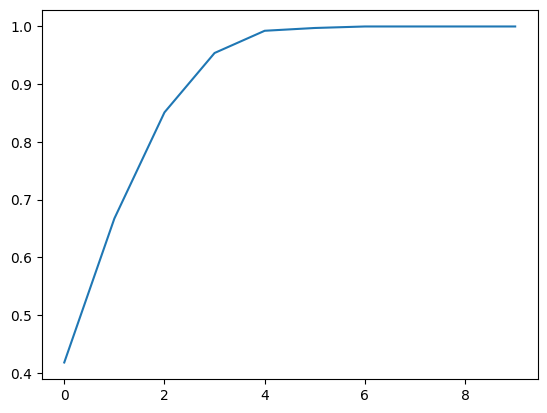

In [87]:
plt.plot(pca.explained_variance_ratio_.cumsum())

In [100]:
Q, R = jnp.linalg.qr(model['column_factors'])
jnp.dot(xs[0,:,:], Q)

Array([[-1.61036491e-01,  2.07657754e-01, -6.02605104e-01],
       [-1.55370310e-01,  2.06443191e-01, -5.98592699e-01],
       [-1.50143519e-01,  2.05360174e-01, -5.95078826e-01],
       [-1.45336986e-01,  2.04406068e-01, -5.91998279e-01],
       [-1.40928566e-01,  2.03581005e-01, -5.89293301e-01],
       [-1.36894345e-01,  2.02889428e-01, -5.86911917e-01],
       [-1.33209959e-01,  2.02342093e-01, -5.84808290e-01],
       [-1.29851237e-01,  2.01957986e-01, -5.82940102e-01],
       [-1.26794785e-01,  2.01767370e-01, -5.81269562e-01],
       [-1.24018669e-01,  2.01815367e-01, -5.79760313e-01],
       [-1.21502586e-01,  2.02165544e-01, -5.78377545e-01],
       [-1.19228147e-01,  2.02904746e-01, -5.77086568e-01],
       [-1.17179275e-01,  2.04146817e-01, -5.75851977e-01],
       [-1.15342177e-01,  2.06036538e-01, -5.74637890e-01],
       [-1.13705605e-01,  2.08750650e-01, -5.73406518e-01],
       [ 1.46990553e-01,  3.88458323e+00, -7.08466947e-01],
       [ 1.23028658e-01,  3.51529980e+00

In [105]:
recurrent_components = jnp.einsum('ctn,nr->ctr', xs, Q)
recurrent_components.shape

(12, 110, 3)

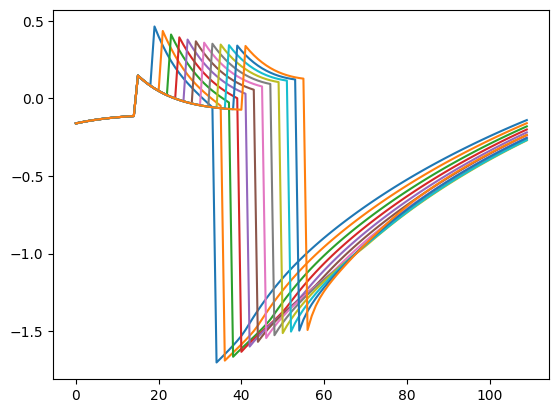

In [107]:
plt.plot(recurrent_components[:,:,0].T)

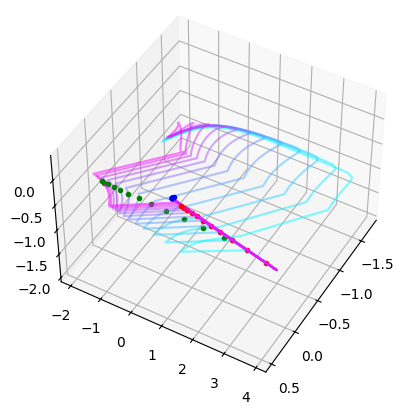

wandb: Network error (ConnectionError), entering retry loop.


In [140]:
ax = plt.figure().add_subplot(projection='3d')

ax.prop_cycle = plt.cycler("color", plt.cm.cool(jnp.linspace(0,1,12)))

for i in range(12):
    ax.plot(recurrent_components[i,:,0], recurrent_components[i,:,1], recurrent_components[i,:,2],alpha=0.5)
    ax.plot(recurrent_components[i,10,0], recurrent_components[i,10,1], recurrent_components[i,10,2], '.', color='b')
    ax.plot(recurrent_components[i,10+new_intervals[0,i],0], recurrent_components[i,10+new_intervals[0,i],1], recurrent_components[i,10+new_intervals[0,i],2], '.', color='r')
    ax.plot(recurrent_components[i,25+new_intervals[0,i],0], recurrent_components[i,25+new_intervals[0,i],1], recurrent_components[i,25+new_intervals[0,i],2], '.', color='g')


ax.plot(recurrent_components[0,0,0], recurrent_components[0,0,1], recurrent_components[0,0,2], '.', color='b')
ax.view_init(45,30)


In [135]:
new_intervals[0,1]

Array(6, dtype=int32)

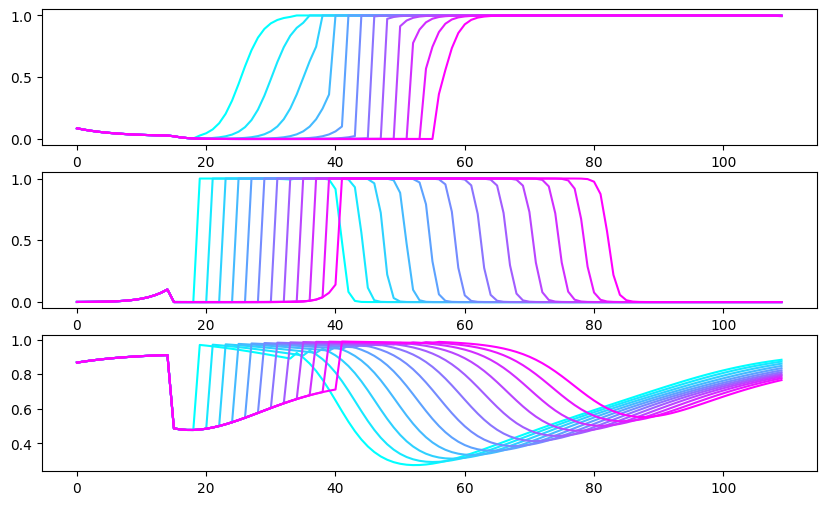

In [123]:
m = model['nm_sigmoid_weight']
b = model['nm_sigmoid_intercept']

fig, axes = plt.subplots(3, 1, figsize=[10,3*2])

for r, ax in enumerate(axes):
    for i in range(12):
        ax.plot(jax.nn.sigmoid((zs @ m.T + b)[i, :, r]))

ValueError: x and y can be no greater than 2D, but have shapes (12,) and (12, 110, 1)

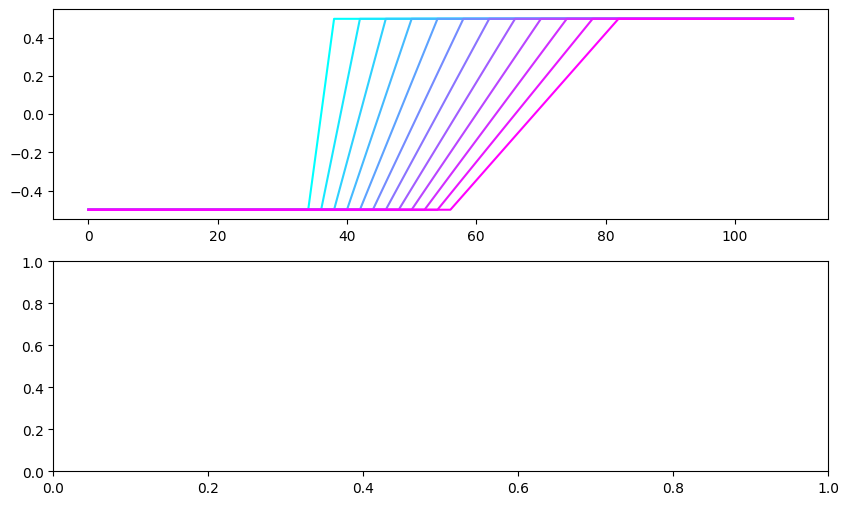

In [130]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=[10, 6])
# ax0.xlabel('Timestep')
ax0.plot(new_outputs[:,:,0].T, label='True target')
ax0.plot(ys, label='RNN target')
# ax0.legend()
# ax1.set_xlabel('Timestep')
# m = model['nm_sigmoid_weight']
# b = model['nm_sigmoid_intercept']
# ax1.plot(jax.nn.sigmoid((zs @ m.T + b)))

In [127]:
new_outputs.shape

(12, 110, 1)

In [179]:
import plotly.express as px
import pandas as pd

df = pd.DataFrame(recurrent_components.reshape(-1, recurrent_components.shape[-1]), columns = ['k1', 'k2', 'k3'])
df['interval'] = jnp.repeat(new_intervals,110).astype(float)
colors = ['red']*4 + ['purple']*4 + ['blue']*4
fig = px.line_3d(df, x="k1", y="k2", z="k3", color='interval', color_discrete_sequence=colors)
fig.show()

/Users/costacurta/nm-rnn/nm_venv/lib/python3.9/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

